In [28]:
#%pip install wfdb neurokit2

In [29]:
import torch
import wfdb
import neurokit2 as nk
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
# print("CUDA disponible:", torch.cuda.is_available())
# print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


In [30]:
records = ["100","101","102","103","104","105","106","107","108","109", "111","112","113","114","115","116","117","118","119", "121","122","123","124","200","201","202","203","205","207","208","209", "210","212","213","214"]
wfdb.dl_database("mitdb", dl_dir="mitdb", records=records)

Generating record list for: 100
Generating record list for: 101
Generating record list for: 102
Generating record list for: 103
Generating record list for: 104
Generating record list for: 105
Generating record list for: 106
Generating record list for: 107
Generating record list for: 108
Generating record list for: 109
Generating record list for: 111
Generating record list for: 112
Generating record list for: 113
Generating record list for: 114
Generating record list for: 115
Generating record list for: 116
Generating record list for: 117
Generating record list for: 118
Generating record list for: 119
Generating record list for: 121
Generating record list for: 122
Generating record list for: 123
Generating record list for: 124
Generating record list for: 200
Generating record list for: 201
Generating record list for: 202
Generating record list for: 203
Generating record list for: 205
Generating record list for: 207
Generating record list for: 208
Generating record list for: 209
Generati

In [31]:
print(os.listdir("mitdb"))

['100.atr', '100.dat', '100.hea', '101.atr', '101.dat', '101.hea', '102.atr', '102.dat', '102.hea', '103.atr', '103.dat', '103.hea', '104.atr', '104.dat', '104.hea', '105.atr', '105.dat', '105.hea', '106.atr', '106.dat', '106.hea', '107.atr', '107.dat', '107.hea', '108.atr', '108.dat', '108.hea', '109.atr', '109.dat', '109.hea', '111.atr', '111.dat', '111.hea', '112.atr', '112.dat', '112.hea', '113.atr', '113.dat', '113.hea', '114.atr', '114.dat', '114.hea', '115.atr', '115.dat', '115.hea', '116.atr', '116.dat', '116.hea', '117.atr', '117.dat', '117.hea', '118.atr', '118.dat', '118.hea', '119.atr', '119.dat', '119.hea', '121.atr', '121.dat', '121.hea', '122.atr', '122.dat', '122.hea', '123.atr', '123.dat', '123.hea', '124.atr', '124.dat', '124.hea', '200.atr', '200.dat', '200.hea', '201.atr', '201.dat', '201.hea', '202.atr', '202.dat', '202.hea', '203.atr', '203.dat', '203.hea', '205.atr', '205.dat', '205.hea', '207.atr', '207.dat', '207.hea', '208.atr', '208.dat', '208.hea', '209.atr'

In [32]:
for record_id in records:
    
    record = wfdb.rdrecord(f"mitdb/{record_id}")
    annotation = wfdb.rdann(f"mitdb/{record_id}", "atr")
    
    print(f"\nRegistro {record_id}")
    print("Frecuencia:", record.fs)
    print("Duración (seg):", len(record.p_signal)/record.fs)
    print("Forma señal:", record.p_signal.shape)
    print("Anotaciones:", len(annotation.sample))

print("Número de anotaciones:", len(annotation.sample))



Registro 100
Frecuencia: 360
Duración (seg): 1805.5555555555557
Forma señal: (650000, 2)
Anotaciones: 2274

Registro 101
Frecuencia: 360
Duración (seg): 1805.5555555555557
Forma señal: (650000, 2)
Anotaciones: 1874

Registro 102
Frecuencia: 360
Duración (seg): 1805.5555555555557
Forma señal: (650000, 2)
Anotaciones: 2192

Registro 103
Frecuencia: 360
Duración (seg): 1805.5555555555557
Forma señal: (650000, 2)
Anotaciones: 2091

Registro 104
Frecuencia: 360
Duración (seg): 1805.5555555555557
Forma señal: (650000, 2)
Anotaciones: 2311

Registro 105
Frecuencia: 360
Duración (seg): 1805.5555555555557
Forma señal: (650000, 2)
Anotaciones: 2691

Registro 106
Frecuencia: 360
Duración (seg): 1805.5555555555557
Forma señal: (650000, 2)
Anotaciones: 2098

Registro 107
Frecuencia: 360
Duración (seg): 1805.5555555555557
Forma señal: (650000, 2)
Anotaciones: 2140

Registro 108
Frecuencia: 360
Duración (seg): 1805.5555555555557
Forma señal: (650000, 2)
Anotaciones: 1824

Registro 109
Frecuencia: 36

In [33]:
unique_symbols = set(annotation.symbol)
print("Clases encontradas en este registro:")
print(unique_symbols)

Clases encontradas en este registro:
{'~', 'L', '"', 'Q', '+', 'F', 'V', '|'}


In [ ]:
def load_record(record_id, base_dir="mitdb", channel=0, window_sec=0.8, target_size=288):
    
    record = wfdb.rdrecord(f"{base_dir}/{record_id}")
    ann = wfdb.rdann(f"{base_dir}/{record_id}", "atr")
    
    signal = record.p_signal[:, channel]
    fs = record.fs
    
    window_size = int(window_sec * fs)
    half = window_size // 2
    
    X_local = []
    y_local = []
    
    for sample, symbol in zip(ann.sample, ann.symbol):
        
        if symbol in ["+", "~", "|","/"]:
            continue
        
        start = sample - half
        end = sample + half
        
        if start > 0 and end < len(signal):
            beat = signal[start:end]
            
            # Forzar tamaño fijo
            if len(beat) == target_size:
                X_local.append(beat)
                y_local.append(symbol)
    
    return np.array(X_local), np.array(y_local)


In [35]:
X_all = []
y_all = []

for r in records:
    Xr, yr = load_record(r)
    print(r, Xr.shape, set(yr))
    
    X_all.append(Xr)
    y_all.append(yr)

X_all = np.concatenate(X_all)
y_all = np.concatenate(y_all)

print("TOTAL:", X_all.shape)
print("Clases totales:", set(y_all))


100 (2271, 288) {np.str_('V'), np.str_('A'), np.str_('N')}
101 (1864, 288) {np.str_('A'), np.str_('Q'), np.str_('N')}
102 (159, 288) {np.str_('V'), np.str_('N'), np.str_('f')}
103 (2083, 288) {np.str_('A'), np.str_('N')}
104 (849, 288) {np.str_('V'), np.str_('Q'), np.str_('N'), np.str_('f')}
105 (2572, 288) {np.str_('V'), np.str_('Q'), np.str_('N')}
106 (2027, 288) {np.str_('V'), np.str_('N')}
107 (59, 288) {np.str_('V')}
108 (1773, 288) {np.str_('j'), np.str_('x'), np.str_('N'), np.str_('V'), np.str_('A'), np.str_('F')}
109 (2530, 288) {np.str_('V'), np.str_('F'), np.str_('L')}
111 (2124, 288) {np.str_('V'), np.str_('L')}
112 (2537, 288) {np.str_('A'), np.str_('N')}
113 (1794, 288) {np.str_('a'), np.str_('N')}
114 (1879, 288) {np.str_('J'), np.str_('N'), np.str_('V'), np.str_('A'), np.str_('F')}
115 (1952, 288) {np.str_('N')}
116 (2411, 288) {np.str_('V'), np.str_('A'), np.str_('N')}
117 (1534, 288) {np.str_('A'), np.str_('N')}
118 (2287, 288) {np.str_('V'), np.str_('R'), np.str_('x')

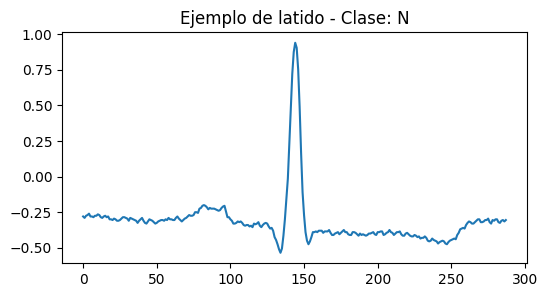

In [37]:
plt.figure(figsize=(6,3))
plt.plot(X_all[0])
plt.title(f"Ejemplo de latido - Clase: {y_all[0]}")
plt.show()

In [38]:
unique, count = np.unique(y_all, return_counts=True)
distribution = dict(zip(unique,count))

print(f"Distribucion de clases {distribution}")

Distribucion de clases {np.str_('!'): np.int64(472), np.str_('"'): np.int64(1), np.str_('A'): np.int64(769), np.str_('E'): np.int64(106), np.str_('F'): np.int64(775), np.str_('J'): np.int64(32), np.str_('L'): np.int64(8071), np.str_('N'): np.int64(52242), np.str_('Q'): np.int64(33), np.str_('R'): np.int64(5605), np.str_('S'): np.int64(2), np.str_('V'): np.int64(4672), np.str_('['): np.int64(6), np.str_(']'): np.int64(6), np.str_('a'): np.int64(149), np.str_('f'): np.int64(722), np.str_('j'): np.int64(16), np.str_('x'): np.int64(58)}


In [39]:
y_binary = np.where(y_all == "N", 0, 1)
unique, count = np.unique(y_binary, return_counts=True)
print(f"Distribucion de clases {dict(zip(unique,count))}")


Distribucion de clases {np.int64(0): np.int64(52242), np.int64(1): np.int64(21495)}


In [40]:
x_train,x_temp, y_train,y_temp = train_test_split(X_all,y_binary, test_size=0.3, random_state=42, stratify=y_binary)

In [41]:
x_val, x_test, y_val, y_test = train_test_split(x_temp,y_temp, test_size=2/3, random_state=42, stratify=y_temp)

In [42]:
print("Train:", x_train.shape, dict(zip(*np.unique(y_train, return_counts=True))))
print("Val:  ", x_val.shape, dict(zip(*np.unique(y_val, return_counts=True))))
print("Test: ", x_test.shape, dict(zip(*np.unique(y_test, return_counts=True))))

Train: (51615, 288) {np.int64(0): np.int64(36569), np.int64(1): np.int64(15046)}
Val:   (7374, 288) {np.int64(0): np.int64(5224), np.int64(1): np.int64(2150)}
Test:  (14748, 288) {np.int64(0): np.int64(10449), np.int64(1): np.int64(4299)}


In [43]:

# Calcular media y std SOLO del entrenamiento
mean = x_train.mean()
std = x_train.std()

print("Mean:", mean)
print("Std:", std)

# Normalizar
X_train = (x_train - mean) / std
X_val = (x_val - mean) / std
X_test = (x_test - mean) / std

Mean: -0.3539956545927648
Std: 0.4796612559298687


In [44]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

print("Train tensor shape:", X_train_tensor.shape)

Train tensor shape: torch.Size([51615, 1, 288])


In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando:", device)

X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)

X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)

X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)


Usando: cuda


In [46]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)


In [47]:
class ECG_CNN(nn.Module):
    
    def __init__(self):
        super(ECG_CNN, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(16)
        
        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(32)
        
        self.pool = nn.MaxPool1d(kernel_size=2)
        
        self.dropout = nn.Dropout(0.3)
        
        self.fc1 = nn.Linear(32 * 72, 64)
        self.fc2 = nn.Linear(64, 2)
        
    def forward(self, x):
        
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        
        x = x.view(x.size(0), -1)
        
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x


In [48]:
model = ECG_CNN().to(device)

dummy = torch.randn(1, 1, 288).to(device)
output = model(dummy)

print("Output shape:", output.shape)


Output shape: torch.Size([1, 2])


In [49]:
class_counts = np.bincount(y_train)
class_weights = torch.tensor(
    [1.0/class_counts[0], 1.0/class_counts[1]],
    dtype=torch.float32
).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)


In [50]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
def train_model(model, train_loader, val_loader, epochs=10):
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        for xb, yb in train_loader:
            
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validación
        model.eval()
        val_preds = []
        val_true = []
        
        with torch.no_grad():
            for xb, yb in val_loader:
                outputs = model(xb)
                preds = torch.argmax(outputs, dim=1)
                
                val_preds.extend(preds.cpu().numpy())
                val_true.extend(yb.cpu().numpy())
        
        f1 = f1_score(val_true, val_preds)
        
        print(f"Epoch {epoch+1}/{epochs} - Loss: {train_loss/len(train_loader):.4f} - Val F1: {f1:.4f}")


In [52]:
train_model(model, train_loader, val_loader, epochs=35)

Epoch 1/35 - Loss: 0.1462 - Val F1: 0.9554
Epoch 2/35 - Loss: 0.0826 - Val F1: 0.9713
Epoch 3/35 - Loss: 0.0657 - Val F1: 0.9717
Epoch 4/35 - Loss: 0.0595 - Val F1: 0.9782
Epoch 5/35 - Loss: 0.0515 - Val F1: 0.9806
Epoch 6/35 - Loss: 0.0496 - Val F1: 0.9770
Epoch 7/35 - Loss: 0.0437 - Val F1: 0.9809
Epoch 8/35 - Loss: 0.0400 - Val F1: 0.9817
Epoch 9/35 - Loss: 0.0381 - Val F1: 0.9821
Epoch 10/35 - Loss: 0.0353 - Val F1: 0.9786
Epoch 11/35 - Loss: 0.0339 - Val F1: 0.9841
Epoch 12/35 - Loss: 0.0333 - Val F1: 0.9823
Epoch 13/35 - Loss: 0.0325 - Val F1: 0.9814
Epoch 14/35 - Loss: 0.0295 - Val F1: 0.9820
Epoch 15/35 - Loss: 0.0302 - Val F1: 0.9841
Epoch 16/35 - Loss: 0.0310 - Val F1: 0.9846
Epoch 17/35 - Loss: 0.0247 - Val F1: 0.9837
Epoch 18/35 - Loss: 0.0265 - Val F1: 0.9855
Epoch 19/35 - Loss: 0.0242 - Val F1: 0.9846
Epoch 20/35 - Loss: 0.0225 - Val F1: 0.9828
Epoch 21/35 - Loss: 0.0254 - Val F1: 0.9848
Epoch 22/35 - Loss: 0.0224 - Val F1: 0.9828
Epoch 23/35 - Loss: 0.0207 - Val F1: 0.98

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

model.eval()

test_preds = []
test_true = []

with torch.no_grad():
    for xb, yb in test_loader:
        outputs = model(xb)
        preds = torch.argmax(outputs, dim=1)
        
        test_preds.extend(preds.cpu().numpy())
        test_true.extend(yb.cpu().numpy())

print("Test F1:", f1_score(test_true, test_preds))
print("\nClassification Report:\n")
print(classification_report(test_true, test_preds))
print("\nConfusion Matrix:\n")
print(confusion_matrix(test_true, test_preds))


Test F1: 0.9813073261349123

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10449
           1       0.98      0.98      0.98      4299

    accuracy                           0.99     14748
   macro avg       0.99      0.99      0.99     14748
weighted avg       0.99      0.99      0.99     14748


Confusion Matrix:

[[10361    88]
 [   73  4226]]


In [54]:
len(test_true)

14748